# Importing Necessary Libraries

In [50]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import random as rng

# Steps

1. Load Image
2. pre-process for edge detection: Grayscale the image
3. pre-process for edge detection: Reduce noise by blurring
4. Edge Detection: Canny
5. Find Contours

## 1. Loading the image

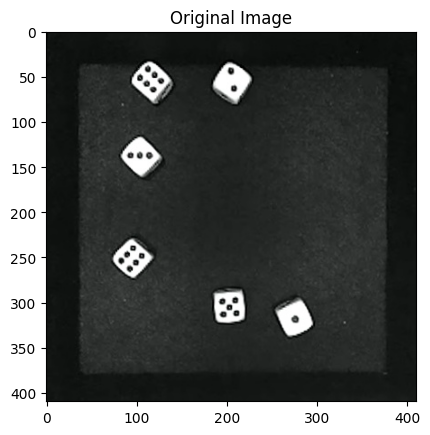

In [51]:
img_orig = cv.imread('photos/test-images/Dice (1).jpg')
plt.title('Original Image')
plt.imshow(img_orig)
plt.show()

## 2. Pre-process for edge detection: Grayscale the image

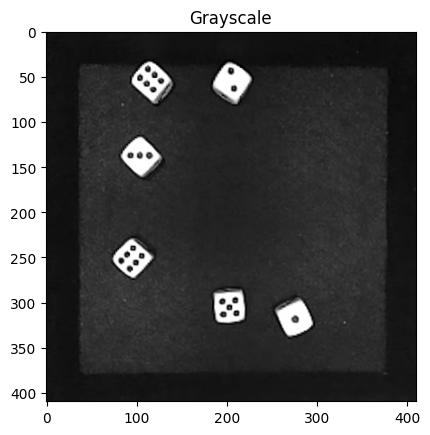

In [52]:
# Convert image to gray
img_gray = cv.cvtColor(img_orig, cv.COLOR_BGR2GRAY)
plt.title('Grayscale')
plt.imshow(img_gray, cmap='gray')
plt.show()

## 3. Pre-process for edge detection: Blurring the image to reduce noise

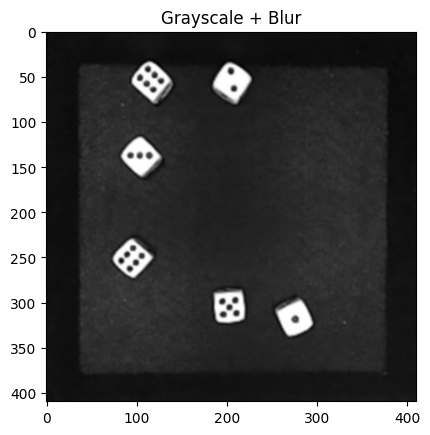

In [53]:
# Blurring the image
img_blur = cv.blur(img_gray, (3,3))
plt.title('Grayscale + Blur')
plt.imshow(img_blur, cmap='gray')
plt.show()

## 4. Edge detection using Canny

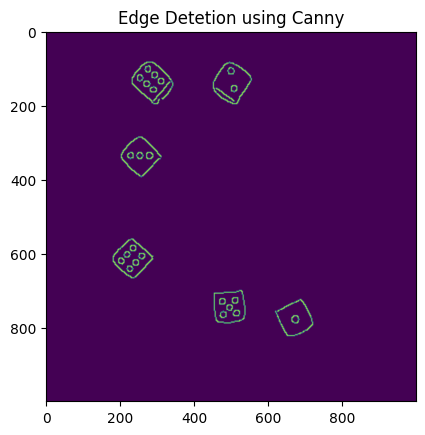

In [54]:
# Detect edges using Canny
threshold = 200
canny_output = cv.Canny(img_blur, threshold, threshold * 2)
plt.title('Edge Detetion using Canny')
plt.imshow(cv.resize(canny_output, (1000,1000)))
plt.show()

## 5. Drawing Contours

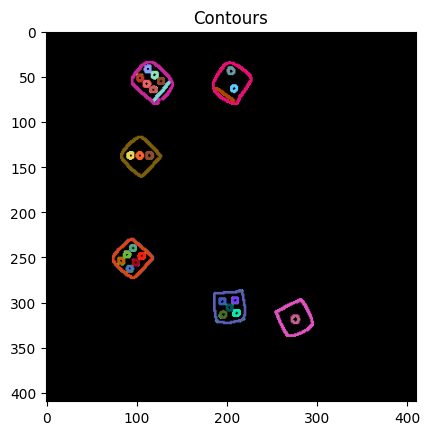

In [55]:
# Find contours
contours, hierarchy = cv.findContours(canny_output, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

# Draw contours
rng.seed(12345)
drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv.drawContours(drawing, contours, i, color, 2, cv.LINE_8, hierarchy, 0)

plt.imshow(drawing)
plt.title('Contours')
plt.show()

The shape and dots of the dice were successfully detected, at least for the current image. As shown, the contour finding algorithm of opencv was able to detect and distinguish the shape of the dice and the dots from each other. Unfortunately, some of the side of the dice were visible to the camera and was detected by Canny. They appear as lines inside the dice in the Canny image.